# PicTex Text Detection Model

Len Huang. Given a square image of handwritten text, return its class.

### Step 1: Import Dataset

Taken from TowardsDataScience.
https://discuss.pytorch.org/t/transforming-3-channel-image-to-greyscale-1-channel/48463/5

In [56]:
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch

# Choose either colored / grayscale
num_output_channels = 1
normal = (0.5,) # uncomment this for grayscale
# normal = (0.5, 0.5, 0.5) # uncomment this for colored


data_dir = 'datasets/our_images_final/'
def load_split_train_test(datadir, valid_size = .2):
    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels),
         transforms.Resize((32, 32)), 
         transforms.ToTensor(),
         transforms.Normalize(normal, normal)])
    train_data = datasets.ImageFolder(datadir, transform)
    test_data = datasets.ImageFolder(datadir, transform)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)

# WE'LL NEED TO DEFINE CLASSES FOR LATER
classes = trainloader.dataset.classes
print("Classes are:")
print(classes)
print("Train loader is:")
print(trainloader)
print("Test loader is:")
print(testloader)

Classes are:
['(', ')', '+', ',', '=', 'a', 'ast', 'b', 'c', 'cong', 'd', 'e', 'f', 'full_stop', 'g', 'geq', 'h', 'i', 'iff', 'implies', 'j', 'k', 'l', 'leq', 'm', 'minus', 'n', 'neq', 'o', 'p', 'plus', 'q', 'r', 's', 'sum', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train loader is:
Test loader is:


### Step 1.5? Image Augmentation

In [57]:
# TODO: Image augmentation

### Step 2: Create CNN

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(num_output_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # idk what this does
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        # not sure what 5 is...
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# init the class 
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=42, bias=True)
)


### Step 3: Loss Function and Optimizer

Adam/SGD and Cross Entrop Loss

In [59]:
import torch.optim as optim

# set parameters
learning_rate = 0.001
momentum = 0.9

def loss_optim():
    criterion = nn.CrossEntropyLoss()
    # Adam Max
    optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    # Adam
    # optimizer = optim.Adam(model.parameters(), learning_rate)
    # SGD. Momentum = remembering previous estimation change for a param (delta W)
    # optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    return criterion, optimizer

criterion, optimizer = loss_optim()
print(criterion)
print(optimizer)

CrossEntropyLoss()
Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)


### Step 4: Train Model

========================================BEGIN TRAINING=======================================
|  [Epoch: 1, Batch: 10]   Train loss: 0.631  |  Test loss: 3.663  |  Test accuracy: 0.031  |
|  [Epoch: 1, Batch: 20]   Train loss: 0.624  |  Test loss: 3.681  |  Test accuracy: 0.062  |
|  [Epoch: 1, Batch: 30]   Train loss: 0.605  |  Test loss: 3.512  |  Test accuracy: 0.156  |
|  [Epoch: 1, Batch: 40]   Train loss: 0.585  |  Test loss: 3.442  |  Test accuracy: 0.047  |
|  [Epoch: 1, Batch: 50]   Train loss: 0.540  |  Test loss: 3.164  |  Test accuracy: 0.109  |
|  [Epoch: 2, Batch: 10]   Train loss: 0.926  |  Test loss: 2.711  |  Test accuracy: 0.203  |
|  [Epoch: 2, Batch: 20]   Train loss: 0.444  |  Test loss: 2.345  |  Test accuracy: 0.328  |
|  [Epoch: 2, Batch: 30]   Train loss: 0.409  |  Test loss: 2.260  |  Test accuracy: 0.328  |
|  [Epoch: 2, Batch: 40]   Train loss: 0.381  |  Test loss: 2.409  |  Test accuracy: 0.344  |
|  [Epoch: 2, Batch: 50]   Train loss: 0.362  |  Test loss: 

|  [Epoch: 18, Batch: 20]   Train loss: 0.022  |  Test loss: 0.143  |  Test accuracy: 0.969  |
|  [Epoch: 18, Batch: 30]   Train loss: 0.023  |  Test loss: 0.059  |  Test accuracy: 1.000  |
|  [Epoch: 18, Batch: 40]   Train loss: 0.025  |  Test loss: 0.240  |  Test accuracy: 0.906  |
|  [Epoch: 18, Batch: 50]   Train loss: 0.027  |  Test loss: 0.100  |  Test accuracy: 0.984  |
|  [Epoch: 19, Batch: 10]   Train loss: 0.063  |  Test loss: 0.131  |  Test accuracy: 0.969  |
|  [Epoch: 19, Batch: 20]   Train loss: 0.026  |  Test loss: 0.206  |  Test accuracy: 0.938  |
|  [Epoch: 19, Batch: 30]   Train loss: 0.025  |  Test loss: 0.106  |  Test accuracy: 0.969  |
|  [Epoch: 19, Batch: 40]   Train loss: 0.024  |  Test loss: 0.120  |  Test accuracy: 0.984  |
|  [Epoch: 19, Batch: 50]   Train loss: 0.023  |  Test loss: 0.093  |  Test accuracy: 0.984  |
|  [Epoch: 20, Batch: 10]   Train loss: 0.049  |  Test loss: 0.102  |  Test accuracy: 1.000  |
|  [Epoch: 20, Batch: 20]   Train loss: 0.024  |  

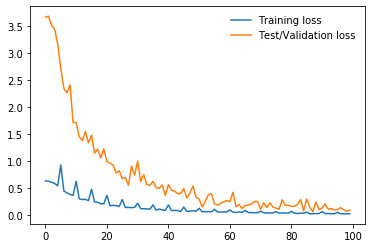

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

def train_network():
    
    # Choose parameters
    num_epoch = 20
    mini_batch = 10
    train_losses, test_losses = [], []
    running_loss = 0
    
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # print statistics
            if i % mini_batch == mini_batch - 1:    # print every # of mini-batches
                test_loss = 0
                accuracy = 0
                # begin evaluation of validation loss
                model.eval()
                with torch.no_grad():
                    for inputs_test, labels_test in testloader:
                        # GPU Optimization
                        # inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))    
                print(f"|  [Epoch: {epoch + 1}, Batch: {i + 1}]   "
                      f"Train loss: {running_loss/len(trainloader):.3f}  |  "
                      f"Test loss: {test_loss/len(testloader):.3f}  |  "
                      f"Test accuracy: {accuracy/len(testloader):.3f}  |")
                running_loss = 0
                model.train()
            
    
    PATH = './models/pictex_text_detect.pt'
    torch.save(model.state_dict(), PATH)
    return train_losses, test_losses, PATH

def visualize_train(train_losses, test_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test/Validation loss')
    plt.legend(frameon=False)
    plt.show()

print("========================================BEGIN TRAINING=======================================")
train_losses, test_losses, PATH = train_network()
print("=========================================END TRAINING========================================")
visualize_train(train_losses, test_losses)

### Step 5: Test the Network

https://stackoverflow.com/questions/13214809/pretty-print-2d-python-list

In [61]:
import torchvision.utils as tvu


# Function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # numpy-ify image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display Content in 8 rows 8 cols matrix
def display_class(labels):
    results = []
    for i in range(8):
        row = []
        for j in range(8):
            index = i + 1 * j
            prediction = classes[labels[index]]
            row.append(prediction)
        results.append(row)
    # Fancy code I found on StackOverflow
    s = [[str(e) for e in row] for row in results]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))
    
        

def test_data():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(tvu.make_grid(images))
    display_class(labels)

    test_data()

In [62]:
# Code to predict a single image!

from PIL import Image

def predict(image_path):
    # Make new CNN object and load model
    model = Net()
    model.load_state_dict(torch.load('./models/pictex_text_detect.pth'))
    # Load image 
    transform = transforms.Compose(
        [
            transforms.Grayscale(1),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )
    image = transform(Image.open(image_path))
    image = image.unsqueeze(0)
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    print(f'Predicted: {classes[predicted[0]]}')
    print(outputs)

predict("./datasets/our_images_final/a/fig10.png")

Predicted: a
tensor([[-61.1412, -33.4641, -36.1585, -10.2410, -11.5347,  13.2473, -12.1343,
          -8.1367, -15.3492, -15.3576,  -2.3706,  -9.5313, -23.4165, -16.7077,
         -10.7739, -39.7042, -18.5667, -17.9899,  -4.7149, -17.5386, -15.6745,
         -13.8291, -11.9097, -35.0041,  -0.8499,  -5.2381,  -5.6388, -26.4796,
          -1.2542, -13.5273, -35.2540,  -9.3291, -21.9567,  -6.9783,  -9.3264,
         -44.4744, -11.1323, -28.1059,  -3.7552,  -2.5839, -17.4165, -25.3632]],
       grad_fn=<AddmmBackward>)


In [63]:
# Code to get overall analysis. Not sure what's going on lol
model = Net()
model.load_state_dict(torch.load('./models/pictex_text_detect.pt'))

class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print(f"For {classes[i]}, {class_correct[i]} / {class_total[i]} were correct")

For (, 0.0 / 1.0 were correct
For ), 0.0 / 0.0 were correct
For +, 1.0 / 1.0 were correct
For ,, 0.0 / 1.0 were correct
For =, 0.0 / 0.0 were correct
For a, 7.0 / 7.0 were correct
For ast, 0.0 / 0.0 were correct
For b, 1.0 / 1.0 were correct
For c, 1.0 / 1.0 were correct
For cong, 0.0 / 0.0 were correct
For d, 3.0 / 3.0 were correct
For e, 1.0 / 1.0 were correct
For f, 0.0 / 0.0 were correct
For full_stop, 0.0 / 0.0 were correct
For g, 2.0 / 2.0 were correct
For geq, 0.0 / 0.0 were correct
For h, 0.0 / 1.0 were correct
For i, 2.0 / 2.0 were correct
For iff, 0.0 / 0.0 were correct
For implies, 2.0 / 2.0 were correct
For j, 1.0 / 1.0 were correct
For k, 1.0 / 2.0 were correct
For l, 2.0 / 3.0 were correct
For leq, 1.0 / 1.0 were correct
For m, 1.0 / 1.0 were correct
For minus, 1.0 / 1.0 were correct
For n, 1.0 / 2.0 were correct
For neq, 0.0 / 0.0 were correct
For o, 2.0 / 3.0 were correct
For p, 4.0 / 4.0 were correct
For plus, 1.0 / 2.0 were correct
For q, 2.0 / 2.0 were correct
For r,